# Importing Libraries

This notebook requires some libaries, these can be installed using `pip install <library>`

In [ ]:
from pattern.en import parse
from pattern.en import pprint
from pattern.en import sentiment

from flair.models import TextClassifier
from flair.data import Sentence
from multiprocessing import Pool, cpu_count
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random 
import os
import warnings
import nltk
import json
import csv
from wordcloud import WordCloud
from IPython import display
from nltk.stem import WordNetLemmatizer
from nltk.probability import MLEProbDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import ngrams, FreqDist
import mplcursors
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
stopwords = set(stopwords.words('english'))

%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

In [2]:
# Create a dictionary with all categories of YouTube videos
with open('dataset/categories.json') as f:
  data = json.load(f)
  CATEGORIES = {int(category["id"]): category["snippet"]["title"] for category in data["items"]}

# Preprocessing and loading the datasets
This preprocessing can take a long time with a large dataset (a few hours for a million records). That is why we save our preprocessed dataframe to disk to be able to load it later.

In [ ]:
#With original dislikes dataset
comments_1 = pd.read_csv('dataset/comments_1.csv', error_bad_lines=False)
videos_1 = pd.read_csv('dataset/videos_1.csv', error_bad_lines=False)

#With Return YouTube dislikes on new videos
comments_2 = pd.read_csv('dataset/comments_2.csv', error_bad_lines=False)
videos_2 = pd.read_csv('dataset/videos_2.csv', error_bad_lines=False)

print("Old dataset videos shape:", videos_1.shape, "and comments:", comments_1.shape)
print("New dataset videos shape:", videos_2.shape, "and comments:", comments_2.shape)

In [ ]:
# Check for duplicate videos
print(videos_1.shape, "vs",videos_1.drop_duplicates(subset=['video_id']).shape)
print(videos_2.shape, "vs",videos_2.drop_duplicates(subset=['video_id']).shape)

videos_1 = videos_1.sort_values(by=['video_id', 'dislikes'], ascending=False).drop_duplicates(subset=['video_id']) 
#videos_2 = videos_2.drop_duplicates(subset=['video_id'])
# Our own gathered dataset does not contain duplicate videos, but the old one does.

print(comments_1.shape, "vs", comments_1.drop_duplicates(subset=['video_id','comment_text']).shape)
print(comments_2.shape, "vs", comments_2.drop_duplicates(subset=['video_id','comment_text']).shape)
comments_1 = comments_1.drop_duplicates(subset=['video_id','comment_text'])

## Choosing a sentiment library
We have to chooose between 3 different sentiment libraries. We do this by taking 25 samples from both datasets and annotating them manually. This is done already and the results can be loaded. In the end we choose between a combination of Flair and NLTK with the result being defined as:
$$\texttt{sentiment} = \begin{cases} 
      0 & \text{if }\texttt{nltk} = 0 \\
      \texttt{flair} & \text{otherwise}
   \end{cases}$$

In [10]:
def precision(y, y_hat):
  result = 0
  for i in range(len(y)):
    if(round(y[i]) == y_hat[i]):
      result += 1
  return result/len(y)

def recall(y, y_hat):
  result = 0
  total = 0
  for i in range(len(y)):
    if y_hat[i] != 0:
      total += 1
      if(round(y[i]) == y_hat[i]):
        result += 1
  return result/total

In [11]:
comments_annotated = pd.read_csv('dataset/sample_comments_annotated.csv', error_bad_lines=False)
comments_annotated["Sentiment Flair"] = comments_annotated["Sentiment Flair"].apply(lambda x: float(x.replace(',','.')))
comments_annotated["Sentiment NLTK"] = comments_annotated["Sentiment NLTK"].apply(lambda x: float(x.replace(',','.')))
comments_annotated["Sentiment Pattern"] = comments_annotated["Sentiment Pattern"].apply(lambda x: float(x.replace(',','.')))

In [76]:
print("Precision of Pattern", precision(comments_annotated["Sentiment Pattern"], comments_annotated["Sentiment Label"]))
print("Recall of Pattern", recall(comments_annotated["Sentiment Pattern"], comments_annotated["Sentiment Label"]))
print("Precision of Flair", precision(comments_annotated["Sentiment Flair"], comments_annotated["Sentiment Label"]))
print("Recall of Flair", recall(comments_annotated["Sentiment Flair"], comments_annotated["Sentiment Label"]))
print("Precision of NLTK", precision(comments_annotated["Sentiment NLTK"], comments_annotated["Sentiment Label"]))
print("Recall of NLTK", recall(comments_annotated["Sentiment NLTK"], comments_annotated["Sentiment Label"]))

Precision of Pattern 0.5
Recall of Pattern 0.3235294117647059
Precision of Flair 0.5
Recall of Flair 0.7352941176470589
Precision of NLTK 0.48
Recall of NLTK 0.38235294117647056


In [13]:
# This is the function we use to compute our sentiment
def best_sentiment(base, flair):
  if base == 0:
    return 0
  else:
    return flair

In [14]:
comments_annotated["Sentiment Combined"] = comments_annotated.apply(lambda row : best_sentiment(row["Sentiment NLTK"], row["Sentiment Flair"]), axis = 1)

In [75]:
print("Precision of combined", precision(comments_annotated["Sentiment Combined"], comments_annotated["Sentiment Label"]))
print("Recall of combined", recall(comments_annotated["Sentiment Combined"], comments_annotated["Sentiment Label"]))

Precision of combined 0.56
Recall of combined 0.6176470588235294


## Performing the sentiment analysi

In [16]:
def tokenize_comment(sentence):
  return ' '.join([wnl.lemmatize(word) for word in sentence.split() if word not in stopwords])

def flair_prediction(x):
  sentence = Sentence(x)
  sia.predict(sentence)
  if "POSITIVE" in str(sentence):
    return sentence.score
  elif "NEGATIVE" in str(sentence):
    return -sentence.score
  else:
    return 0

In [17]:
# Perform Sentiment Analysis using the Pattern Library on all comments

# Dataset 1
comments_1['Sentiment Pattern'] = comments_1['comment_text'].apply(lambda x: sentiment(x)[0])
comments_2['Sentiment Pattern'] = comments_2['comment_text'].apply(lambda x: sentiment(x)[0])

In [18]:
# NLTK Library
wnl = WordNetLemmatizer()
# comments_1.dropna(inplace=True)
# comments_1 = comments_1.reset_index().drop('index',axis=1)
comments_1['comment_text_processed'] = comments_1['comment_text']
comments_1['comment_text_processed'] = comments_1['comment_text_processed'].str.replace("[^a-zA-Z#]", " ")
comments_1['comment_text_processed'] = comments_1['comment_text_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
comments_1['comment_text_processed'] = comments_1['comment_text_processed'].apply(lambda x:x.lower())
comments_1['comment_text_processed'] = comments_1['comment_text_processed'].apply(tokenize_comment)
    
# comments_2.dropna(inplace=True)
# comments_2 = comments_2.reset_index().drop('index',axis=1)
comments_2['comment_text_processed'] = comments_2['comment_text']
comments_2['comment_text_processed'] = comments_2['comment_text_processed'].str.replace("[^a-zA-Z#]", " ")
comments_2['comment_text_processed'] = comments_2['comment_text_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
comments_2['comment_text_processed'] = comments_2['comment_text_processed'].apply(lambda x:x.lower())
comments_2['comment_text_processed'] = comments_2['comment_text_processed'].apply(tokenize_comment)

sia = SentimentIntensityAnalyzer()
comments_1['Sentiment NLTK'] = comments_1['comment_text_processed'].apply(lambda x:sia.polarity_scores(x)['compound'])
comments_2['Sentiment NLTK'] = comments_2['comment_text_processed'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [ ]:
# Flair Library
sia = TextClassifier.load('en-sentiment')
comments_1["Sentiment Flair"] = comments_1["comment_text"].apply(flair_prediction)
comments_2["Sentiment Flair"] = comments_2["comment_text"].apply(flair_prediction)

In [ ]:
# Combine the libaries
comments_1["Sentiment Scores"] = comments_1.apply(lambda row : best_sentiment(row["Sentiment NLTK"], row["Sentiment Flair"]), axis = 1)
comments_2["Sentiment Scores"] = comments_2.apply(lambda row : best_sentiment(row["Sentiment NLTK"], row["Sentiment Flair"]), axis = 1)
comments_1['Sentiment'] = comments_1['Sentiment Scores'].apply(lambda s : 'Positive' if s > 0 else ('Neutral' if s == 0 else 'Negative'))
comments_2['Sentiment'] = comments_2['Sentiment Scores'].apply(lambda s : 'Positive' if s > 0 else ('Neutral' if s == 0 else 'Negative'))

print("Dataset 1: \n", comments_1.Sentiment.value_counts())
print("Dataset 2: \n", comments_2.Sentiment.value_counts())

## Calculating the sentiment scores of comments per video

In [22]:
# Calculate sentiment scores per video on dataset 1
v_comments = {'nr_comments': [], 'nr_comments_neutral': [], 'nr_comments_positive': [], 'nr_comments_negative': [], 'sentiment': [], 'sentiment_positive': [], 'sentiment_negative': []}
for v in videos_1.video_id:
  v_nr_comments = comments_1[comments_1.video_id == v].count()[0]
  v_nr_comments_neutral = comments_1[(comments_1.video_id == v) & (comments_1.Sentiment == 'Neutral')].count()[0]
  v_nr_comments_positive = comments_1[(comments_1.video_id == v) & (comments_1.Sentiment == 'Positive')].count()[0]
  v_nr_comments_negative = comments_1[(comments_1.video_id == v) & (comments_1.Sentiment == 'Negative')].count()[0]
  v_sentiment_positive = comments_1[(comments_1.video_id == v) & (comments_1.Sentiment == 'Positive')]['Sentiment Scores'].sum()
  v_sentiment_negative = comments_1[(comments_1.video_id == v) & (comments_1.Sentiment == 'Negative')]['Sentiment Scores'].sum()
  v_sentiment = comments_1[comments_1.video_id == v]['Sentiment Scores'].sum()
  v_comments['nr_comments'].append(v_nr_comments)
  v_comments['nr_comments_neutral'].append(v_nr_comments_neutral)
  v_comments['nr_comments_positive'].append(v_nr_comments_positive)
  v_comments['nr_comments_negative'].append(v_nr_comments_negative)
  v_comments['sentiment'].append(v_sentiment)
  v_comments['sentiment_positive'].append(v_sentiment_positive)
  v_comments['sentiment_negative'].append(v_sentiment_negative)

videos_1['sentiment'] = v_comments['sentiment']
videos_1['sentiment_positive'] = v_comments['sentiment_positive']
videos_1['sentiment_negative'] = v_comments['sentiment_negative']

videos_1['comment_retrieved'] = v_comments['nr_comments']
videos_1['comment_neutral'] = v_comments['nr_comments_neutral']
videos_1['comment_positive'] = v_comments['nr_comments_positive']
videos_1['comment_negative'] = v_comments['nr_comments_negative']

videos_1['sentiment_per_comment'] = videos_1['sentiment'] / videos_1['comment_retrieved']
videos_1['positive_sentiment_per_comment'] = videos_1['sentiment_positive'] / videos_1['comment_positive']
videos_1['negative_sentiment_per_comment'] = videos_1['sentiment_negative'] / videos_1['comment_negative']
videos_1['sentiment_per_non_neutral_comment'] = videos_1['sentiment'] / (videos_1['comment_retrieved'] - videos_1['comment_neutral'])

In [23]:
# Calculate sentiment scores per video on dataset 2
v_comments = {'nr_comments': [], 'nr_comments_neutral': [], 'nr_comments_positive': [], 'nr_comments_negative': [], 'sentiment': [], 'sentiment_positive': [], 'sentiment_negative': []}
for v in videos_2.video_id:
  v_nr_comments = comments_2[comments_2.video_id == v].count()[0]
  v_nr_comments_neutral = comments_2[(comments_2.video_id == v) & (comments_2.Sentiment == 'Neutral')].count()[0]
  v_nr_comments_positive = comments_2[(comments_2.video_id == v) & (comments_2.Sentiment == 'Positive')].count()[0]
  v_nr_comments_negative = comments_2[(comments_2.video_id == v) & (comments_2.Sentiment == 'Negative')].count()[0]
  v_sentiment_positive = comments_2[(comments_2.video_id == v) & (comments_2.Sentiment == 'Positive')]['Sentiment Scores'].sum()
  v_sentiment_negative = comments_2[(comments_2.video_id == v) & (comments_2.Sentiment == 'Negative')]['Sentiment Scores'].sum()
  v_sentiment = comments_2[comments_2.video_id == v]['Sentiment Scores'].sum()
  v_comments['nr_comments'].append(v_nr_comments)
  v_comments['nr_comments_neutral'].append(v_nr_comments_neutral)
  v_comments['nr_comments_positive'].append(v_nr_comments_positive)
  v_comments['nr_comments_negative'].append(v_nr_comments_negative)
  v_comments['sentiment'].append(v_sentiment)
  v_comments['sentiment_positive'].append(v_sentiment_positive)
  v_comments['sentiment_negative'].append(v_sentiment_negative)

videos_2['sentiment'] = v_comments['sentiment']
videos_2['sentiment_positive'] = v_comments['sentiment_positive']
videos_2['sentiment_negative'] = v_comments['sentiment_negative']

videos_2['comment_retrieved'] = v_comments['nr_comments']
videos_2['comment_neutral'] = v_comments['nr_comments_neutral']
videos_2['comment_positive'] = v_comments['nr_comments_positive']
videos_2['comment_negative'] = v_comments['nr_comments_negative']

videos_2['sentiment_per_comment'] = videos_2['sentiment'] / videos_2['comment_retrieved']
videos_2['positive_sentiment_per_comment'] = videos_2['sentiment_positive'] / videos_2['comment_positive']
videos_2['negative_sentiment_per_comment'] = videos_2['sentiment_negative'] / videos_2['comment_negative']
videos_2['sentiment_per_non_neutral_comment'] = videos_2['sentiment'] / (videos_2['comment_retrieved'] - videos_2['comment_neutral'])

In [ ]:
print("Dataset 1:")
print("Average sentiment on dataset per video", videos_1['sentiment'].sum()/videos_1.count()[0])
print("Average sentiment on dataset per comment", videos_1['sentiment_per_comment'].sum()/videos_1.count()[0])
print("Average non-neutral sentiment on dataset per video per comment", videos_1['sentiment_per_non_neutral_comment'].sum()/videos_1.count()[0])
print("Dataset 2:")
print("Average sentiment on dataset per video", videos_2['sentiment'].sum()/videos_2.count()[0])
print("Average sentiment on dataset per comment", videos_2['sentiment_per_comment'].sum()/videos_2.count()[0])
print("Average non-neutral sentiment on dataset per video per comment", videos_2['sentiment_per_non_neutral_comment'].sum()/videos_2.count()[0])

## Saving our data to a file

In [25]:
# Save to file
output_dir = "dataset/preprocessed"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

videos_1.to_csv(f"{output_dir}/videos_1_processed.csv", encoding='utf-8', index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
videos_2.to_csv(f"{output_dir}/videos_2_processed.csv", encoding='utf-8', index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
comments_1.to_csv(f"{output_dir}/comments_1_processed.csv", encoding='utf-8', index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
comments_2.to_csv(f"{output_dir}/comments_2_processed.csv", encoding='utf-8', index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

# Gathering results
## Loading the data

In [ ]:
# Load from file
input_dir = "data/youtube_comment/preprocessed" #"dataset/preprocessed"

videos_1 = pd.read_csv(f"{input_dir}/videos_1_processed.csv")
videos_2 = pd.read_csv(f"{input_dir}/videos_2_processed.csv")
comments_1 = pd.read_csv(f"{input_dir}/comments_1_processed.csv")
comments_2 = pd.read_csv(f"{input_dir}/comments_2_processed.csv")
print("Old dataset videos shape:", videos_1.shape, "and comments:", comments_1.shape)
print("New dataset videos shape:", videos_2.shape, "and comments:", comments_2.shape)

In [ ]:
# Remove videos with less than 200/500 comments
videos_1 = videos_1[videos_1.comment_retrieved >= 200]
videos_2 = videos_2[videos_2.comment_retrieved >= 500]

# Remove videos with 0 dislikes (this never happens in practice, so it must be an error)
videos_1 = videos_1[videos_1.dislikes > 0]
videos_2 = videos_2[videos_2.dislikes > 0]
print("New shape of old dataset:", videos_1.shape)
print("New shape of new dataset:", videos_2.shape)

## Plots

In [60]:
img_dir = "img"
if not os.path.exists(img_dir):
  os.makedirs(img_dir)

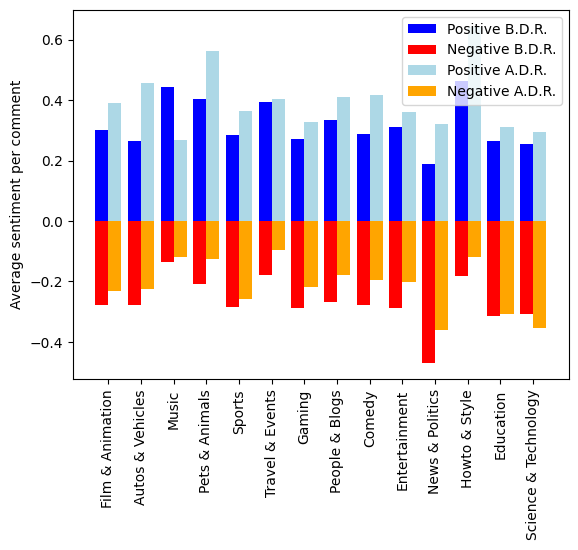

In [61]:
# Numbers of pairs of bars you want
categories = videos_1.category_id.unique().tolist()
categories.sort()
N = len(categories)

X = [CATEGORIES[x] for x in categories]

Y_1_1 = []
Y_1_2 = []
Y_2_1 = []
Y_2_2 = []

for categorie in categories:
  num_videos = sum(videos_1[videos_1['category_id'] == categorie]['comment_retrieved'])
  Y_1_1.append(videos_1[videos_1['category_id'] == categorie]['sentiment_positive'].sum()/num_videos)
  Y_1_2.append(videos_1[videos_1['category_id'] == categorie]['sentiment_negative'].sum()/num_videos)
  num_videos = sum(videos_2[videos_2['category_id'] == categorie]['comment_retrieved'])
  Y_2_1.append(videos_2[videos_2['category_id'] == categorie]['sentiment_positive'].sum()/num_videos)
  Y_2_2.append(videos_2[videos_2['category_id'] == categorie]['sentiment_negative'].sum()/num_videos)

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
#plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.4       

# Plotting
plt.bar(ind, Y_1_1 , width, color='blue', label='Positive B.D.R.')
plt.bar(ind, Y_1_2 , width, color='red', label='Negative B.D.R.')
plt.bar(ind + width, Y_2_1, width, color='lightblue', label='Positive A.D.R.')
plt.bar(ind + width, Y_2_2, width, color='orange', label='Negative A.D.R.')

plt.ylabel("Average sentiment per comment")
#plt.title('Average sentiment per categorie')

plt.xticks(ind + width / 2, X, rotation='vertical')

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig(f"{img_dir}/categories.svg", bbox_inches = "tight")
plt.show()

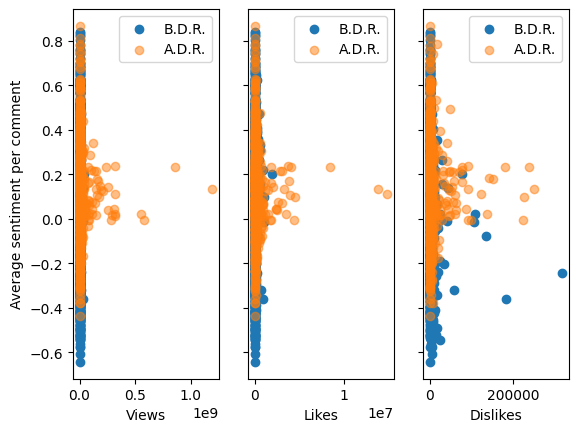

In [62]:
# Plots met sentiment tegen likes, dislikes en views voor beide datasets
X_1 = videos_1['sentiment_per_comment']
Y_1_1 = videos_1['views']
Y_1_2 = videos_1['likes']
Y_1_3 = videos_1['dislikes']

X_2 = videos_2['sentiment_per_comment']
Y_2_1 = videos_2['views']
Y_2_2 = videos_2['likes']
Y_2_3 = videos_2['dislikes']

fig, ax = plt.subplots(1,3)

ax[0].scatter(Y_1_1, X_1, alpha=1, label="B.D.R.")
ax[0].scatter(Y_2_1, X_2, alpha=0.5, label="A.D.R.")
ax[0].legend()
ax[0].set_ylabel('Average sentiment per comment')
ax[0].set_xlabel('Views')

ax[1].tick_params(labelleft = False)
ax[1].scatter(Y_1_2, X_1, alpha=1, label="B.D.R.")
ax[1].scatter(Y_2_2, X_2, alpha=0.5, label="A.D.R.")
ax[1].legend()
ax[1].set_xlabel('Likes')

ax[2].tick_params(labelleft = False)
ax[2].scatter(Y_1_3, X_1, alpha=1, label="B.D.R.")
ax[2].scatter(Y_2_3, X_2, alpha=0.5, label="A.D.R.")
ax[2].legend()
ax[2].set_xlabel('Dislikes')
plt.savefig(f"{img_dir}/scatter_plot.svg", bbox_inches = "tight")

<function matplotlib.pyplot.show(close=None, block=None)>

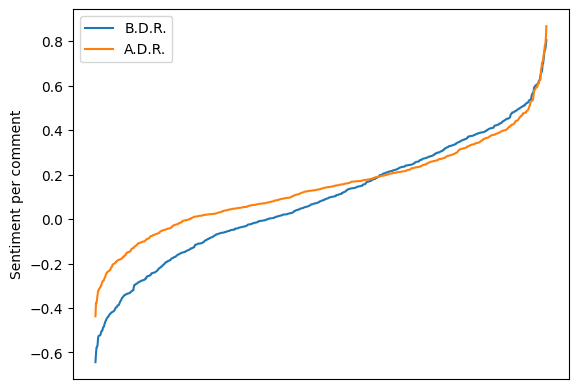

In [63]:
videos_new = videos_2
videos_old = videos_1.sample(len(videos_new))

X_4_1 = range(len(videos_old))
Y_4_1 = videos_old.sort_values(by=["sentiment_per_comment"])['sentiment_per_comment']

X_4_2 = range(len(videos_new))
Y_4_2 = videos_new.sort_values(by=["sentiment_per_comment"])['sentiment_per_comment']

plt.plot(X_4_1, Y_4_1, label="B.D.R.")
plt.plot(X_4_2, Y_4_2, label="A.D.R.")
plt.legend()
#plt.set_title('Distribution of Sentiment per comment')
plt.ylabel('Sentiment per comment')
plt.tick_params(labelbottom = False, bottom = False)


plt.savefig(f"{img_dir}/sentiment_plot.svg", bbox_inches = "tight")
plt.show

## Word clouds

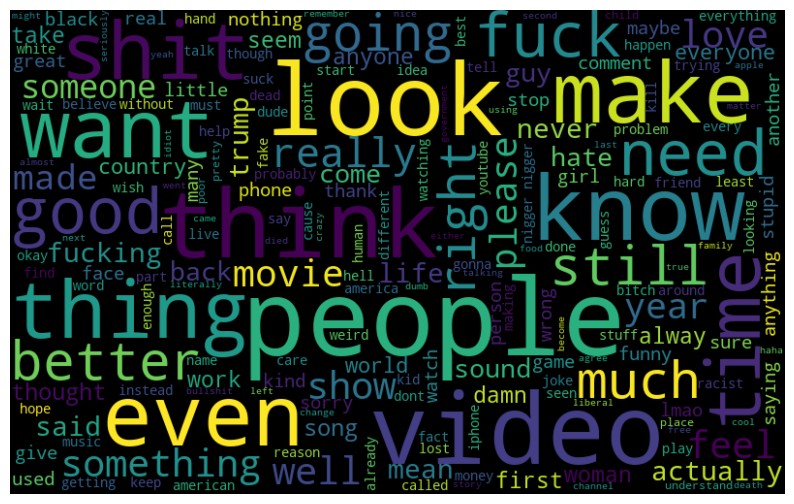

In [64]:
# ALl old words
all_words = ' '.join([str(text) for text in comments_1[comments_1['Sentiment'] == "Negative"]['comment_text_processed']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

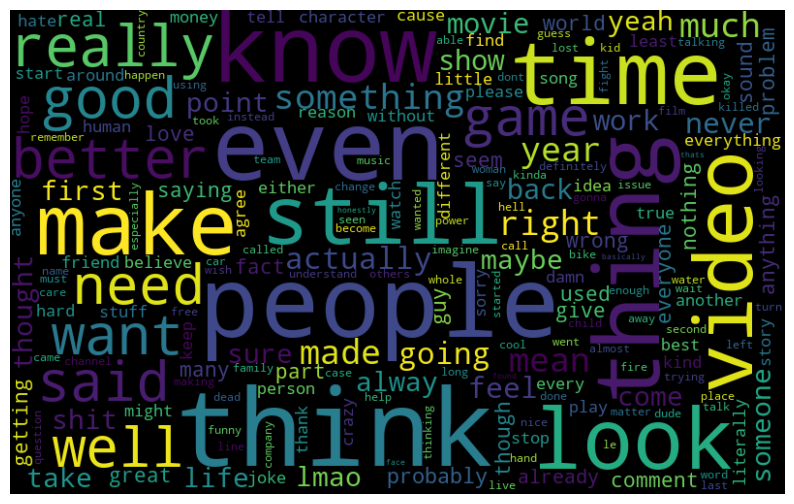

In [65]:
# ALl new words
all_words = ' '.join([str(text) for text in comments_2[comments_2['Sentiment'] == "Negative"]['comment_text_processed']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### N-GRAM Wordclouds (not used in the paper)

In [ ]:
'''
A function to extract ngrams for every tweet in a frame. 
If not present, adds a column with the list of n-grams to the frame.
Its name is dependent on n.
'''
def extract_and_add_ngrams(frame, token_column, n):

  pool = Pool(cpu_count())
  # See FAQ in case your local machine raises an error here
  extractor_func = partial(extract_ngram_freqs, n=n)
  list_of_grams = pool.map(extractor_func, [str(sentence).split(' ') for sentence in frame.comment_text_processed])
  pool.close()

  # so grams1, grams2 and so on
  name = 'grams' + str(n)
  frame[name] = list_of_grams
  return name

def plot_dist_as_cloud(word_dist):
  prob_dist = MLEProbDist(word_dist)
  viz_dict = {}
  for word_tuple in word_dist:
    string = ' '.join(word_tuple)
    viz_dict[string] = prob_dist.prob(word_tuple)

  cloud = WordCloud(width=800, height=500).generate_from_frequencies(viz_dict)
  plt.figure(figsize=(10, 7))
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

def extract_ngram_freqs(token_list, n):
  grams = list(ngrams(token_list, n))
  cleaned_grams = []
  for word_tuple in grams:
    if len(word_tuple) == len(set(word_tuple)):
      for word in word_tuple:
          if word not in stopwords and word not in cleaned_grams: # consider each term only once per comment
              cleaned_grams.append(word_tuple)
              break
  
  return cleaned_grams

In [ ]:
n = 4
column_name = extract_and_add_ngrams(comments_1,'immediately_after', n = n)

word_dist = FreqDist()
for grams in comments_1[column_name]:
  word_dist.update(FreqDist(grams))

print(f'Found {len(word_dist)} unique n-grams for n = {n}')

most_common = word_dist.most_common(25)
for word_tuple in most_common:
  print(word_tuple)

plot_dist_as_cloud(word_dist)

## Validating the data
We look for channels that are in both datasets and then inspect the videos in both sets

In [66]:
def print_video_info(video):
  print(video["title"])
  url = video["thumbnail_link"]
  print("Likes:", video["likes"], "Dislikes:", video["dislikes"], "Comments retrieved:", video["comment_retrieved"])
  print("Sentiment:", video["sentiment"], "sentiment per comment:", video["sentiment_per_comment"], "Positive sentiment per comment:", video["positive_sentiment_per_comment"], "Negative sentiment per comment:", video["negative_sentiment_per_comment"])
  return str(url)

In [67]:
# Get channels that are in both sets
channel_1 = set(videos_1['channel_title'].to_list())
channel_2 = set(videos_2['channel_title'].to_list())

channels = channel_1.intersection(channel_2)

In [68]:
# Get the videos from a channel
channel = random.sample(list(channels), 1)[0]
print(channel)

videos_1_of_channel = videos_1[videos_1['channel_title'] == channel]
videos_2_of_channel = videos_2[videos_2['channel_title'] == channel]

print(len(videos_1_of_channel), "In the old dataset")
print(len(videos_2_of_channel), "In the new dataset")

TMZ
2 In the old dataset
1 In the new dataset


Bella Hadid Roughs Up Security Roughing Up Female Photog | TMZ
Likes: 1369 Dislikes: 1645 Comments retrieved: 800
Sentiment: -310.0241892337799 sentiment per comment: -0.3875302365422249 Positive sentiment per comment: 0.855383633684229 Negative sentiment per comment: -0.9670476813207972


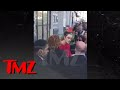

In [73]:
# Sample a video from both sets:
v1 = videos_1_of_channel.sample(1)

url = v1.apply(print_video_info, axis=1).to_list()[0]
display.Image(url, width=300)

Remembering DJ Stephen 'tWitch' Boss, Dead at 40 | TMZ
Likes: 8306.0 Dislikes: 1661 Comments retrieved: 1000
Sentiment: 53.85673743486405 sentiment per comment: 0.053856737434864 Positive sentiment per comment: 0.9304087480376748 Negative sentiment per comment: -0.9206657155826086


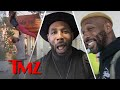

In [74]:
# Sample a video from both sets:
v2 = videos_2_of_channel.sample(1)

url = v2.apply(print_video_info, axis=1).to_list()[0]
display.Image(url, width=300)